In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Binary Classifier (call/no call)

In [2]:
from birdclef.utils import get_spark

spark = get_spark(cores=4, memory="10g")
df = spark.read.parquet(
    "../data/processed/birdclef-2023/train_embeddings/consolidated_v3"
)
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/06 17:57:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- species: string (nullable = true)
 |-- track_stem: string (nullable = true)
 |-- track_type: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- prediction_vec: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- predictions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- rank: long (nullable = true)
 |    |    |-- index: long (nullable = true)
 |    |    |-- label: string (nullable = true)
 |    |    |-- mapped_label: string (nullable = true)
 |    |    |-- probability: double (nullable = true)
 |-- start_time: long (nullable = true)
 |-- energy: double (nullable = true)



### 1. Data Preprocessing

#### 1.1 Positive labels

In [3]:
from pyspark.sql import Window, functions as F

# keep the track_type for the highest energy
highest_energy_channel = (
    df
    # get the track stem without the part
    .withColumn("original_track_stem", F.split(F.col("track_stem"), "_").getItem(0))
    .where("track_type != 'original'")
    # get the track type that has the most energy
    .withColumn(
        "rank",
        F.rank().over(
            Window.partitionBy("original_track_stem").orderBy(F.desc("energy"))
        ),
    )
    # keep the first row
    .where(F.col("rank") == 1)
    # drop the rank column
    .select("species", "track_stem", "track_type")
    .distinct()
)

# get the highest predictions by exploding the values
exploded_embeddings = (
    df
    # join against the highest energy channel
    .join(
        highest_energy_channel,
        on=["species", "track_stem", "track_type"],
        how="inner",
    )
    # explode the embeddings, these are ordered by confidence
    .withColumn("predictions", F.explode("predictions")).select(
        "species",
        "track_stem",
        "track_type",
        "start_time",
        "track_name",
        "embedding",
        "predictions.*",
    )
    # simplifying assumption: we assume the prediction with the highest confidence is the true label
    .where("rank = 0")
).cache()

exploded_embeddings.drop("embedding").show(n=5)

+-------+----------+----------+----------+--------------------+----+-----+--------------------+------------+--------------------+
|species|track_stem|track_type|start_time|          track_name|rank|index|               label|mapped_label|         probability|
+-------+----------+----------+----------+--------------------+----+-----+--------------------+------------+--------------------+
|abythr1|  XC233199|   source0|         0|abythr1/XC233199_...|   0|  639|Chloropsis hardwi...|     orblea1|0.002208352088928...|
|abythr1|  XC233199|   source0|        57|abythr1/XC233199_...|   0| 1151|Erpornis zanthole...|     whbyuh1|0.025502817705273628|
|abythr1|  XC233199|   source0|        27|abythr1/XC233199_...|   0| 3164|Turdus abyssinicu...|     abythr1|0.024902962148189545|
|abythr1|  XC233199|   source0|        30|abythr1/XC233199_...|   0|  639|Chloropsis hardwi...|     orblea1|0.012038093991577625|
|abythr1|  XC233199|   source0|        21|abythr1/XC233199_...|   0| 3185|Turdus leucomela

In [37]:
# quick count of the number of species
counts = (
    exploded_embeddings.groupBy("species")
    .agg(F.count("*").alias("n"))
    .orderBy(F.desc("n"))
)
counts.show(n=5)
counts.orderBy("n").show(n=5)

+-------+-----+
|species|    n|
+-------+-----+
|thrnig1|12987|
| wlwwar| 9249|
|combuz1| 7173|
| hoopoe| 6731|
| barswa| 6191|
+-------+-----+
only showing top 5 rows



+-------+---+
|species|  n|
+-------+---+
|afpkin1|  3|
|whhsaw1|  4|
|whctur2|  4|
|golher1|  5|
|lotlap1|  8|
+-------+---+
only showing top 5 rows



In [38]:
# Prepared DF
rarity_min_count = 100
rare_species_count = (
    exploded_embeddings.groupBy("species")
    .agg(F.count("*").alias("n"))
    .where(f"n < {rarity_min_count}")
)
rare_species_count.show(n=5)

# if there are a lot of examples, we can use a higher threshold
common_species = exploded_embeddings.where("probability > 0.5").join(
    rare_species_count.select("species"), on="species", how="left_anti"
)
# these ones are less common so we use a lower threshold so we have at least one
# example for each species
# rare_species = exploded_embeddings.where("probability > 0.1").join(
#     rare_species_count.select("species"), on="species", how="inner"
# )
prepared = common_species.select("species", "probability", "embedding")
prepared.show(n=5)
print(f"Prepared count: {prepared.count()}")

+-------+---+
|species|  n|
+-------+---+
|purgre2| 60|
|bubwar2| 90|
|rehwea1| 69|
|kvbsun1| 80|
|equaka1| 63|
+-------+---+
only showing top 5 rows



+-------+------------------+--------------------+
|species|       probability|           embedding|
+-------+------------------+--------------------+
|afghor1|0.9965255856513977|[0.57833033800125...|
|afghor1| 0.511886715888977|[1.00166213512420...|
|afghor1|0.9984956979751587|[0.88829582929611...|
|afghor1|0.9988522529602051|[1.26016914844512...|
|afghor1|0.9997662901878357|[1.16302716732025...|
+-------+------------------+--------------------+
only showing top 5 rows



Prepared count: 66352


In [39]:
# lets check that we have the right number of classes, and how many examples we are working with
prepared_counts = (
    prepared.groupBy("species").agg(F.count("*").alias("n")).orderBy(F.desc("n"))
)
print(f"number of species {prepared_counts.count()}")

prepared_counts.show(n=5)
prepared_counts.orderBy("n").show(n=5)

number of species 215


+-------+----+
|species|   n|
+-------+----+
| hoopoe|3633|
|thrnig1|3403|
|eubeat1|2969|
| barswa|2450|
| wlwwar|2416|
+-------+----+
only showing top 5 rows



+-------+---+
|species|  n|
+-------+---+
|raybar1|  3|
|litwea1|  4|
|easmog1|  4|
|whihel1|  4|
|palfly2|  5|
+-------+---+
only showing top 5 rows



#### 1.1 Negative labels

In [18]:
# Negative calls
noise_indices = [
    (1022, "Dog_Dog"),
    (1136, "Engine_Engine"),
    (1141, "Environmental_Environmental"),
    (1219, "Fireworks_Fireworks"),
    (1352, "Gun_Gun"),
    (1449, "Human non-vocal_Human non-vocal"),
    (1450, "Human vocal_Human vocal"),
    (1451, "Human whistle_Human whistle"),
    (1997, "Noise_Noise"),
    (2812, "Siren_Siren"),
]
noise_indices = [i[0] for i in noise_indices]

# Craete negative samples DF
negative_samples = (
    df
    # explode the predictions with their indices
    .select(
        "track_name",
        "start_time",
        "embedding",
        F.posexplode("prediction_vec").alias("index", "logit"),
    )
    .where(F.col("index").isin(noise_indices))
    .withColumn("probability", F.expr("1/(1+exp(-logit))"))
    .where("probability > 0.4")
    .select("track_name", "start_time", F.lit("no_call").alias("species"), "embedding")
).cache()
negative_samples.show()

23/05/23 00:39:20 WARN CacheManager: Asked to cache already cached data.
+--------------------+----------+-------+--------------------+
|          track_name|start_time|species|           embedding|
+--------------------+----------+-------+--------------------+
|hoopoe/XC318438_p...|        66|no_call|[0.47851136326789...|
|litegr/XC332323_p...|       117|no_call|[0.38947930932044...|
|litegr/XC332323_p...|        12|no_call|[0.43516066670417...|
|litegr/XC332323_p...|        12|no_call|[0.43516066670417...|
|litegr/XC332727_p...|        78|no_call|[0.35861393809318...|
|litegr/XC331548_p...|        90|no_call|[0.51571053266525...|
|eubeat1/XC699304_...|         9|no_call|[0.13348712027072...|
|combuz1/XC579930_...|        33|no_call|[0.22507806122303...|
|barswa/XC361240_p...|         0|no_call|[1.25061154365539...|
|combuz1/XC579874_...|        30|no_call|[0.03499644994735...|
|spmthr1/XC602624_...|       123|no_call|[1.07436048984527...|
|blaplo1/XC736812_...|        72|no_call|[0.1

In [19]:
from pyspark.sql.functions import lit

# Get the exploded examples
# Only keep examples less than 0.1
# Every example in the new query is a no-call
# Union with the negative_samples

exploded_negatives = exploded_embeddings.where(exploded_embeddings.probability < 0.1)

# Define fractions for each stratum
fractions = (
    exploded_negatives.select("track_stem")
    .distinct()
    .withColumn("fraction", lit(0.6))
    .rdd.collectAsMap()
)

# Perform stratified sampling
exploded_negative_sub = exploded_negatives.stat.sampleBy(
    "track_stem", fractions, seed=42
)

# Select columns from exploded DF that match negative_samples
exploded_negative_select = exploded_negative_sub.select(negative_samples.columns)

# Perform union operation
negatives = negative_samples.union(exploded_negative_select)

# Set all values in species column to "no_call"
negatives = negatives.withColumn("species", lit("no_call"))

# Check unique values
unique_vals = negatives.select("species").distinct()
unique_values_list = unique_vals.rdd.flatMap(lambda x: x).collect()

print(f"Unique values in species column: {len(unique_values_list)}")
print(f"Number of rows: {negatives.count()}")
negatives.show(n=5)

Unique values in species column: 1


Number of rows: 58978
+--------------------+----------+-------+--------------------+
|          track_name|start_time|species|           embedding|
+--------------------+----------+-------+--------------------+
|hoopoe/XC318438_p...|        66|no_call|[0.47851136326789...|
|litegr/XC332323_p...|       117|no_call|[0.38947930932044...|
|litegr/XC332323_p...|        12|no_call|[0.43516066670417...|
|litegr/XC332323_p...|        12|no_call|[0.43516066670417...|
|litegr/XC332727_p...|        78|no_call|[0.35861393809318...|
+--------------------+----------+-------+--------------------+
only showing top 5 rows



In [24]:
# Import background noise dataset
back_noise_df = spark.read.parquet("../data/processed/birdclef-2023/background_noise")
back_noise_df.printSchema()

# Add a 'species' column to back_noise_df with 'no_call' as values
back_noise_df = back_noise_df.withColumn("species", lit("no_call"))
back_noise_df = back_noise_df.withColumnRenamed("emb", "embedding")

# Make sure 'species' is the first column to math the structure of negatives DF
back_noise_sub = back_noise_df.select("species", "embedding")
negatives_sub = negatives.select("species", "embedding")

# Union the two DFs
negatives_df = negatives_sub.union(back_noise_sub)

# Select positive samples and Union with negatives
positives_sub = prepared.select("species", "embedding")
positives_df = positives_sub.withColumn("species", lit("call"))
binary_df = negatives_df.union(positives_df)
binary_df.show()

root
 |-- row_id: string (nullable = true)
 |-- emb: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- call: double (nullable = true)
 |-- no_call: double (nullable = true)



+-------+--------------------+
|species|           embedding|
+-------+--------------------+
|no_call|[0.47851136326789...|
|no_call|[0.38947930932044...|
|no_call|[0.43516066670417...|
|no_call|[0.43516066670417...|
|no_call|[0.35861393809318...|
|no_call|[0.51571053266525...|
|no_call|[0.13348712027072...|
|no_call|[0.22507806122303...|
|no_call|[1.25061154365539...|
|no_call|[0.03499644994735...|
|no_call|[1.07436048984527...|
|no_call|[0.12970589101314...|
|no_call|[0.26487210392951...|
|no_call|[0.57878917455673...|
|no_call|[0.91182446479797...|
|no_call|[1.38340187072753...|
|no_call|[0.75772899389266...|
|no_call|[0.45265802741050...|
|no_call|[1.00851356983184...|
|no_call|[0.55738186836242...|
+-------+--------------------+
only showing top 20 rows



In [25]:
# Check the number of samples for each label
counts = binary_df.groupBy("species").agg(F.count("*").alias("n")).orderBy(F.desc("n"))
counts.show(n=5)

+-------+-----+
|species|    n|
+-------+-----+
|no_call|67114|
|   call|66352|
+-------+-----+



In [26]:
# Write out res to a parquet file, using 1 or 2 partitions.
# Use the processed/birdnet-2023 folder and make a new dataset under there.
binary_df.repartition(2).write.mode("overwrite").parquet(
    "../data/processed/birdclef-2023/call_no_call_v2"
)

### 2. Model training

In [3]:
from birdclef.utils import get_spark

spark = get_spark(cores=4, memory="10g")
binary_df = spark.read.parquet("../data/processed/birdclef-2023/call_no_call_v2")
binary_df.printSchema()

root
 |-- species: string (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [4]:
# Data for model training
data = binary_df.toPandas()
data.head()

,species,embedding
0,no_call,"[0.43516066670417786, 1.339859962463379, 1.467..."
1,no_call,"[0.12970589101314545, 1.857396125793457, 1.042..."
2,no_call,"[0.03499644994735718, 1.6026946306228638, 0.29..."
3,no_call,"[0.5787891745567322, 1.686322808265686, 0.4741..."
4,no_call,"[0.3586139380931854, 1.1902474164962769, 0.520..."


In [5]:
import time
import numpy as np
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
    classification_report,
)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    np.stack(data["embedding"]),
    data["species"],
    test_size=0.33,
    stratify=data["species"],
)

# Create a label encoder object
le = LabelEncoder()

# Fit and transform the target with label encoder
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Data shape
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(89422, 320) (44044, 320)
(89422,) (44044,)


In [6]:
def model_eval(truth, preds):
    print("Accuracy:", round(accuracy_score(truth, preds), 3))
    print("Precision:", round(precision_score(truth, preds, average="macro"), 3))
    print("Recall:", round(recall_score(truth, preds, average="macro"), 3))
    print("F1 Score:", round(f1_score(truth, preds, average="macro"), 3))

In [7]:
from skopt.space import Real
from skopt import BayesSearchCV
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression

weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train_enc)

# LogisticRegression
lgr_search = BayesSearchCV(
    LogisticRegression(),
    {
        "penalty": ("l2",),
        "C": (0.01, 1.1, "log-uniform"),
    },
    n_iter=10,
    scoring="f1",
    verbose=4,
    cv=3,
    n_points=1,
    n_jobs=-1,
)
%time lgr_search.fit(X_train, y_train_enc, sample_weight=weights)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END ..C=0.8803222498559387, penalty=l2;, score=0.881 total time=   3.9s
[CV 2/3] END ..C=0.8803222498559387, penalty=l2;, score=0.881 total time=   4.5s
[CV 1/3] END ..C=0.8803222498559387, penalty=l2;, score=0.883 total time=   4.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END .C=0.04544153734589794, penalty=l2;, score=0.881 total time=   3.3s
[CV 3/3] END .C=0.04544153734589794, penalty=l2;, score=0.881 total time=   4.6s
[CV 1/3] END .C=0.04544153734589794, penalty=l2;, score=0.884 total time=   4.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END .C=0.27261697926255224, penalty=l2;, score=0.881 total time=   3.5s
[CV 1/3] END .C=0.27261697926255224, penalty=l2;, score=0.883 total time=   4.6s
[CV 3/3] END .C=0.27261697926255224, penalty=l2;, score=0.881 total time=   4.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END .C=0.22516551641596003

BayesSearchCV(cv=3, estimator=LogisticRegression(), n_iter=10, n_jobs=-1,
              scoring='f1',
              search_spaces={'C': (0.01, 1.1, 'log-uniform'),
                             'penalty': ('l2',)},
              verbose=4)

In [8]:
# Evaluate model
model_eval(y_test_enc, lgr_search.predict(X_test))

Accuracy: 0.884
Precision: 0.884
Recall: 0.884
F1 Score: 0.884


In [9]:
import pickle
from pathlib import Path

# Write model to pickle file
pickle.dump(
    lgr_search.best_estimator_,
    Path("../data/models/baseline/logistic_binary_v2.pkl").open("wb"),
)

# Label Encoder to pickle file
pickle.dump(
    le,
    Path("../data/models/baseline/logistic_binary_label_encoder_v2.pkl").open("wb"),
)

In [16]:
from xgboost import XGBClassifier

weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train_enc)

# XGBoost model
xgb_search = BayesSearchCV(
    XGBClassifier(tree_method="gpu_hist"),
    {
        "eta": (0.01, 1.0, "log-uniform"),
        "max_depth": (1, 30, "uniform"),
        "gamma": (0, 1, "uniform"),
        "min_child_weight": (1, 10, "uniform"),
    },
    n_iter=10,
    scoring="f1",
    verbose=4,
    cv=3,
    n_points=1,
    n_jobs=1,
)
%time xgb_search.fit(X_train, y_train_enc, sample_weight=weights)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END eta=0.025534761227908934, gamma=1, max_depth=11, min_child_weight=7;, score=0.853 total time=  18.3s
[CV 2/3] END eta=0.025534761227908934, gamma=1, max_depth=11, min_child_weight=7;, score=0.849 total time=  12.6s
[CV 3/3] END eta=0.025534761227908934, gamma=1, max_depth=11, min_child_weight=7;, score=0.841 total time=  13.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END eta=0.14968195367854237, gamma=0, max_depth=22, min_child_weight=7;, score=0.863 total time=  11.7s
[CV 2/3] END eta=0.14968195367854237, gamma=0, max_depth=22, min_child_weight=7;, score=0.861 total time=  11.5s
[CV 3/3] END eta=0.14968195367854237, gamma=0, max_depth=22, min_child_weight=7;, score=0.854 total time=  11.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END eta=0.04004897299285126, gamma=1, max_depth=14, min_child_weight=6;, score=0.856 total time=  17.1s
[CV 2/3] END eta=0.0400489729

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, ...),
              n_iter=10, scoring='f1',
              search_spaces={'eta': (0.01, 1.0, 'log-uniform'),
                             'gamma': (0, 1, 'uniform'),
                             'max_depth': (1, 30, 'uniform'),
                             'min_child_weight': (1, 10, 'uniform')},
              verbose=4)

In [17]:
# Evaluate model
model_eval(y_test_enc, xgb_search.predict(X_test))

Accuracy: 0.884
Precision: 0.884
Recall: 0.88
F1 Score: 0.881


### Projections of the Call/No call dataset

In [5]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# The "embedding" column contains 320 samples for each row
emb_df = np.stack(data["embedding"].values)
scaled_data = StandardScaler().fit_transform(emb_df)

# Get values for call and no_call
df = pd.DataFrame()
df["species_num"] = data["species"].map({"call": 0, "no_call": 1})
species = df["species_num"].values

# Fit the UMAP model and transform the emb_df
reducer = umap.UMAP()
embedding = reducer.fit_transform(emb_df)

/home/mgustine/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-06 16:22:44.866773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 16:23:02.769885: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-06 16:23:02.770275: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

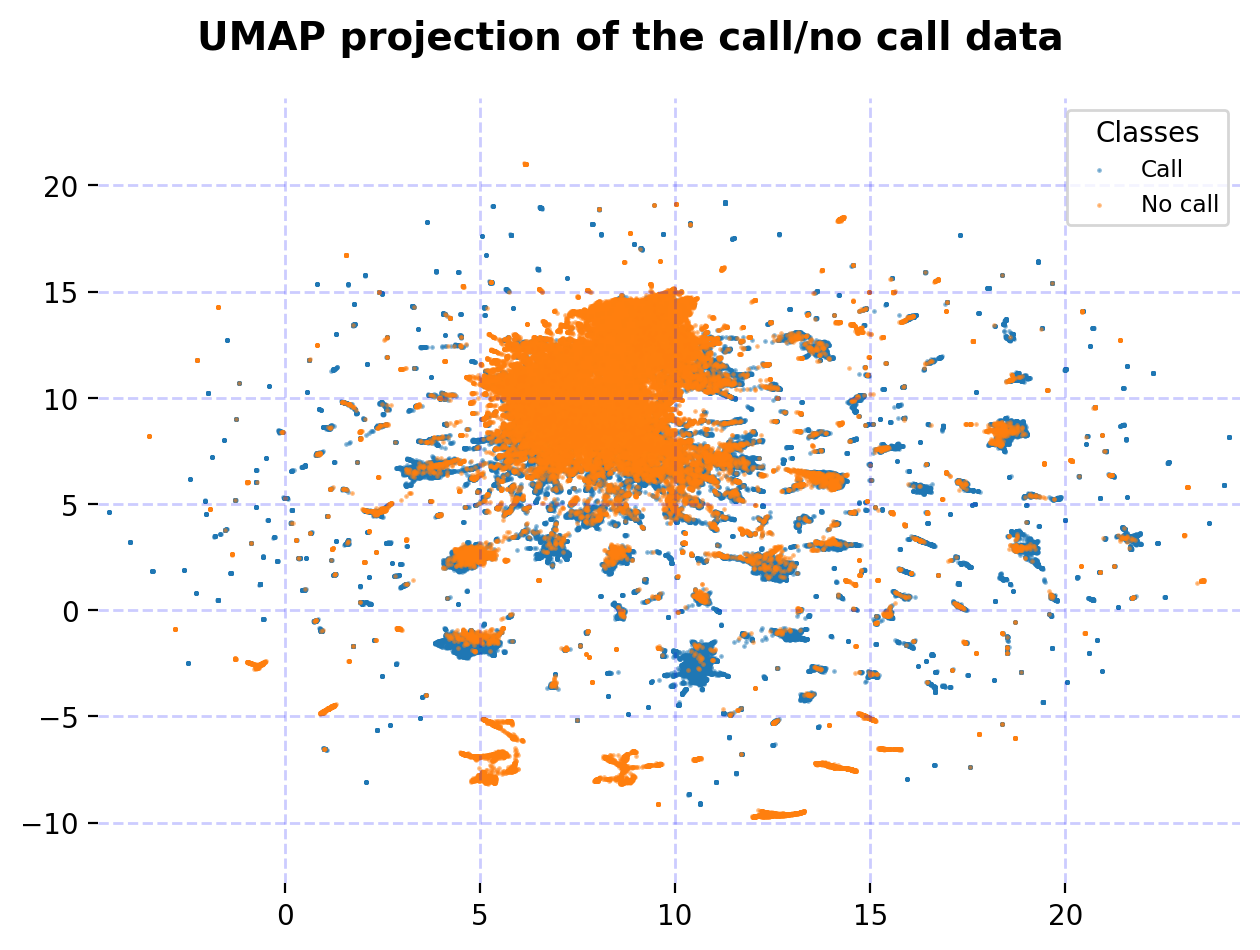

In [12]:
# Plot the data
fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
fig.suptitle("UMAP projection of the call/no call data", fontsize=14, weight="bold")
# Separate the 'call' and 'no_call' groups
embedding_call = embedding[species == 0]
embedding_no_call = embedding[species == 1]
ax.scatter(
    embedding_call[:, 0],
    embedding_call[:, 1],
    color="tab:blue",
    label="Call",
    alpha=0.5,
    s=0.5,
)
ax.scatter(
    embedding_no_call[:, 0],
    embedding_no_call[:, 1],
    color="tab:orange",
    label="No call",
    alpha=0.5,
    s=0.5,
)
ax.margins(x=0.01, y=0.1)  # No margins on x and y-axis
ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
ax.legend(loc="best", title="Classes", fontsize="small")
for spine in ["top", "right", "bottom", "left"]:
    ax.spines[spine].set_visible(False)
fig.tight_layout()
plt.show()

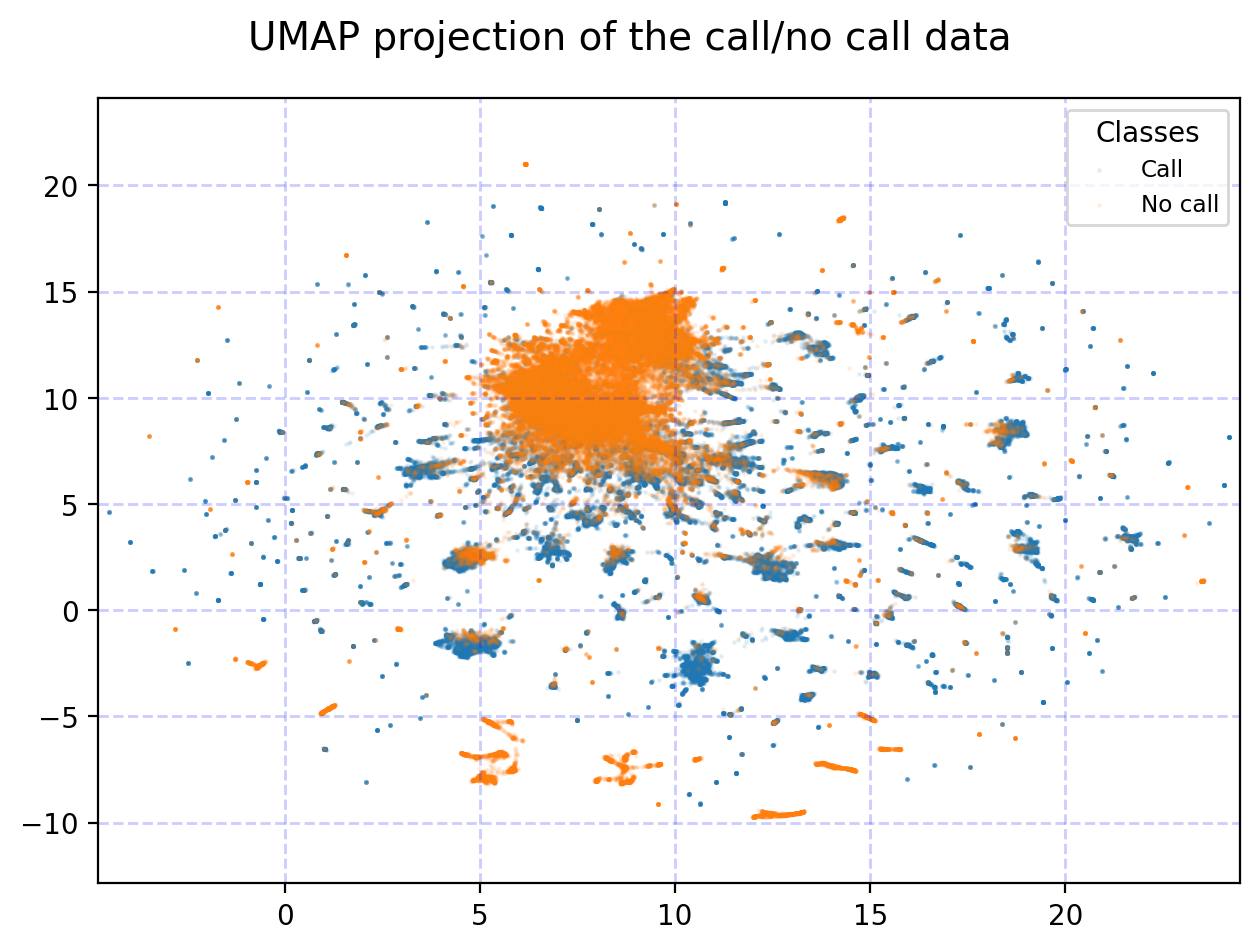

In [15]:
# Plot the data
fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
fig.suptitle("UMAP projection of the call/no call data", fontsize=14)
# Separate the 'call' and 'no_call' groups
embedding_call = embedding[species == 0]
embedding_no_call = embedding[species == 1]
ax.scatter(
    embedding_call[:, 0],
    embedding_call[:, 1],
    color="tab:blue",
    label="Call",
    alpha=0.1,
    s=0.5,
)
ax.scatter(
    embedding_no_call[:, 0],
    embedding_no_call[:, 1],
    color="tab:orange",
    label="No call",
    alpha=0.1,
    s=0.5,
)
ax.margins(x=0.01, y=0.1)  # No margins on x and y-axis
ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
ax.legend(loc="best", title="Classes", fontsize="small")
# for spine in ["top", "right", "bottom", "left"]:
#     ax.spines[spine].set_visible(False)
fig.tight_layout()
plt.show()

### Filter for most common species

In [41]:
from pyspark.sql.functions import col

# Prepared DF
rarity_min_count = 100
rare_species_count = (
    exploded_embeddings.groupBy("species")
    .agg(F.count("*").alias("n"))
    .where(f"n < {rarity_min_count}")
)
rare_species_count.show(n=5)

# if there are a lot of examples, we can use a higher threshold
common_species = exploded_embeddings.where("probability > 0.5").join(
    rare_species_count.select("species"), on="species", how="left_anti"
)

# Filter for most common species == thrnig1
common_species = common_species.where(
    col("species").isin(["thrnig1", "wlwwar", "combuz1"])
)

# Finalized species
prepared = common_species.select("species", "probability", "embedding")
prepared.show(n=5)
print(f"Prepared count: {prepared.count()}")

+-------+---+
|species|  n|
+-------+---+
|purgre2| 60|
|bubwar2| 90|
|rehwea1| 69|
|kvbsun1| 80|
|equaka1| 63|
+-------+---+
only showing top 5 rows



+-------+------------------+--------------------+
|species|       probability|           embedding|
+-------+------------------+--------------------+
| wlwwar|0.5015106201171875|[0.49793550372123...|
| wlwwar| 0.736925482749939|[0.36515399813652...|
| wlwwar|0.7728320956230164|[1.59225749969482...|
| wlwwar|0.8555451035499573|[0.73220539093017...|
| wlwwar|0.9693441390991211|[0.67511063814163...|
+-------+------------------+--------------------+
only showing top 5 rows



Prepared count: 8085


In [5]:
# Negative calls
noise_indices = [
    (1022, "Dog_Dog"),
    (1136, "Engine_Engine"),
    (1141, "Environmental_Environmental"),
    (1219, "Fireworks_Fireworks"),
    (1352, "Gun_Gun"),
    (1449, "Human non-vocal_Human non-vocal"),
    (1450, "Human vocal_Human vocal"),
    (1451, "Human whistle_Human whistle"),
    (1997, "Noise_Noise"),
    (2812, "Siren_Siren"),
]
noise_indices = [i[0] for i in noise_indices]

# Craete negative samples DF
negative_samples = (
    df
    # explode the predictions with their indices
    .select(
        "track_name",
        "start_time",
        "embedding",
        F.posexplode("prediction_vec").alias("index", "logit"),
    )
    .where(F.col("index").isin(noise_indices))
    .withColumn("probability", F.expr("1/(1+exp(-logit))"))
    .where("probability > 0.4")
    .select("track_name", "start_time", F.lit("no_call").alias("species"), "embedding")
).cache()
negative_samples.show()

+--------------------+----------+-------+--------------------+
|          track_name|start_time|species|           embedding|
+--------------------+----------+-------+--------------------+
|hoopoe/XC318438_p...|        66|no_call|[0.47851136326789...|
|litegr/XC332323_p...|       117|no_call|[0.38947930932044...|
|litegr/XC332323_p...|        12|no_call|[0.43516066670417...|
|litegr/XC332323_p...|        12|no_call|[0.43516066670417...|
|litegr/XC332727_p...|        78|no_call|[0.35861393809318...|
|litegr/XC331548_p...|        90|no_call|[0.51571053266525...|
|eubeat1/XC699304_...|         9|no_call|[0.13348712027072...|
|combuz1/XC579930_...|        33|no_call|[0.22507806122303...|
|barswa/XC361240_p...|         0|no_call|[1.25061154365539...|
|combuz1/XC579874_...|        30|no_call|[0.03499644994735...|
|spmthr1/XC602624_...|       123|no_call|[1.07436048984527...|
|blaplo1/XC736812_...|        72|no_call|[0.12970589101314...|
|egygoo/XC109700_s...|        72|no_call|[0.26487210392

In [6]:
from pyspark.sql.functions import lit

# Get the exploded examples
# Only keep examples less than 0.1
# Every example in the new query is a no-call
# Union with the negative_samples

exploded_negatives = exploded_embeddings.where(exploded_embeddings.probability < 0.1)

# Define fractions for each stratum
fractions = (
    exploded_negatives.select("track_stem")
    .distinct()
    .withColumn("fraction", lit(0.6))
    .rdd.collectAsMap()
)

# Perform stratified sampling
exploded_negative_sub = exploded_negatives.stat.sampleBy(
    "track_stem", fractions, seed=42
)

# Select columns from exploded DF that match negative_samples
exploded_negative_select = exploded_negative_sub.select(negative_samples.columns)

# Perform union operation
negatives = negative_samples.union(exploded_negative_select)

# Set all values in species column to "no_call"
negatives = negatives.withColumn("species", lit("no_call"))

# Check unique values
unique_vals = negatives.select("species").distinct()
unique_values_list = unique_vals.rdd.flatMap(lambda x: x).collect()

print(f"Unique values in species column: {len(unique_values_list)}")
print(f"Number of rows: {negatives.count()}")
negatives.show(n=5)

Unique values in species column: 1


Number of rows: 58978
+--------------------+----------+-------+--------------------+
|          track_name|start_time|species|           embedding|
+--------------------+----------+-------+--------------------+
|hoopoe/XC318438_p...|        66|no_call|[0.47851136326789...|
|litegr/XC332323_p...|       117|no_call|[0.38947930932044...|
|litegr/XC332323_p...|        12|no_call|[0.43516066670417...|
|litegr/XC332323_p...|        12|no_call|[0.43516066670417...|
|litegr/XC332727_p...|        78|no_call|[0.35861393809318...|
+--------------------+----------+-------+--------------------+
only showing top 5 rows



In [42]:
# Import background noise dataset
back_noise_df = spark.read.parquet("../data/processed/birdclef-2023/background_noise")
back_noise_df.printSchema()

# Add a 'species' column to back_noise_df with 'no_call' as values
back_noise_df = back_noise_df.withColumn("species", lit("no_call"))
back_noise_df = back_noise_df.withColumnRenamed("emb", "embedding")

# Make sure 'species' is the first column to math the structure of negatives DF
back_noise_sub = back_noise_df.select("species", "embedding")
# negatives_sub = negatives.select("species", "embedding")

# Union the two DFs
# negatives_df = negatives_sub.union(back_noise_sub)

# Select positive samples and Union with negatives
positives_sub = prepared.select("species", "embedding")
positives_df = positives_sub.withColumn("species", lit("call"))
binary_df = back_noise_sub.union(positives_df)
binary_df.show()

root
 |-- row_id: string (nullable = true)
 |-- emb: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- call: double (nullable = true)
 |-- no_call: double (nullable = true)



+-------+--------------------+
|species|           embedding|
+-------+--------------------+
|no_call|[0.92088675498962...|
|no_call|[0.84365564584732...|
|no_call|[1.26694309711456...|
|no_call|[1.38729619979858...|
|no_call|[0.67062968015670...|
|no_call|[0.55484676361083...|
|no_call|[0.76140671968460...|
|no_call|[1.05057728290557...|
|no_call|[1.10778868198394...|
|no_call|[0.97304064035415...|
|no_call|[0.80366438627243...|
|no_call|[0.83019882440567...|
|no_call|[1.27283263206481...|
|no_call|[1.18015515804290...|
|no_call|[1.46877062320709...|
|no_call|[1.15537261962890...|
|no_call|[1.25248849391937...|
|no_call|[1.28011035919189...|
|no_call|[1.57398808002471...|
|no_call|[1.14994704723358...|
+-------+--------------------+
only showing top 20 rows



In [43]:
# Check the number of samples for each label
counts = binary_df.groupBy("species").agg(F.count("*").alias("n")).orderBy(F.desc("n"))
counts.show(n=5)

+-------+----+
|species|   n|
+-------+----+
|no_call|8136|
|   call|8085|
+-------+----+



In [44]:
# Data for model training
data = binary_df.toPandas()
data.head()

,species,embedding
0,no_call,"[0.920886754989624, 0.5779306888580322, 1.2043..."
1,no_call,"[0.8436556458473206, 0.6893028616905212, 1.160..."
2,no_call,"[1.266943097114563, 0.9825764298439026, 1.2696..."
3,no_call,"[1.387296199798584, 0.9537946581840515, 0.9189..."
4,no_call,"[0.6706296801567078, 0.3362767994403839, 0.673..."


In [45]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler

# The "embedding" column contains 320 samples for each row
emb_df = np.stack(data["embedding"].values)
scaled_data = StandardScaler().fit_transform(emb_df)

# Get values for call and no_call
df = pd.DataFrame()
df["species_num"] = data["species"].map({"call": 0, "no_call": 1})
species = df["species_num"].values

# Fit the UMAP model and transform the emb_df
reducer = umap.UMAP()
embedding = reducer.fit_transform(emb_df)

In [46]:
import matplotlib.lines as mlines

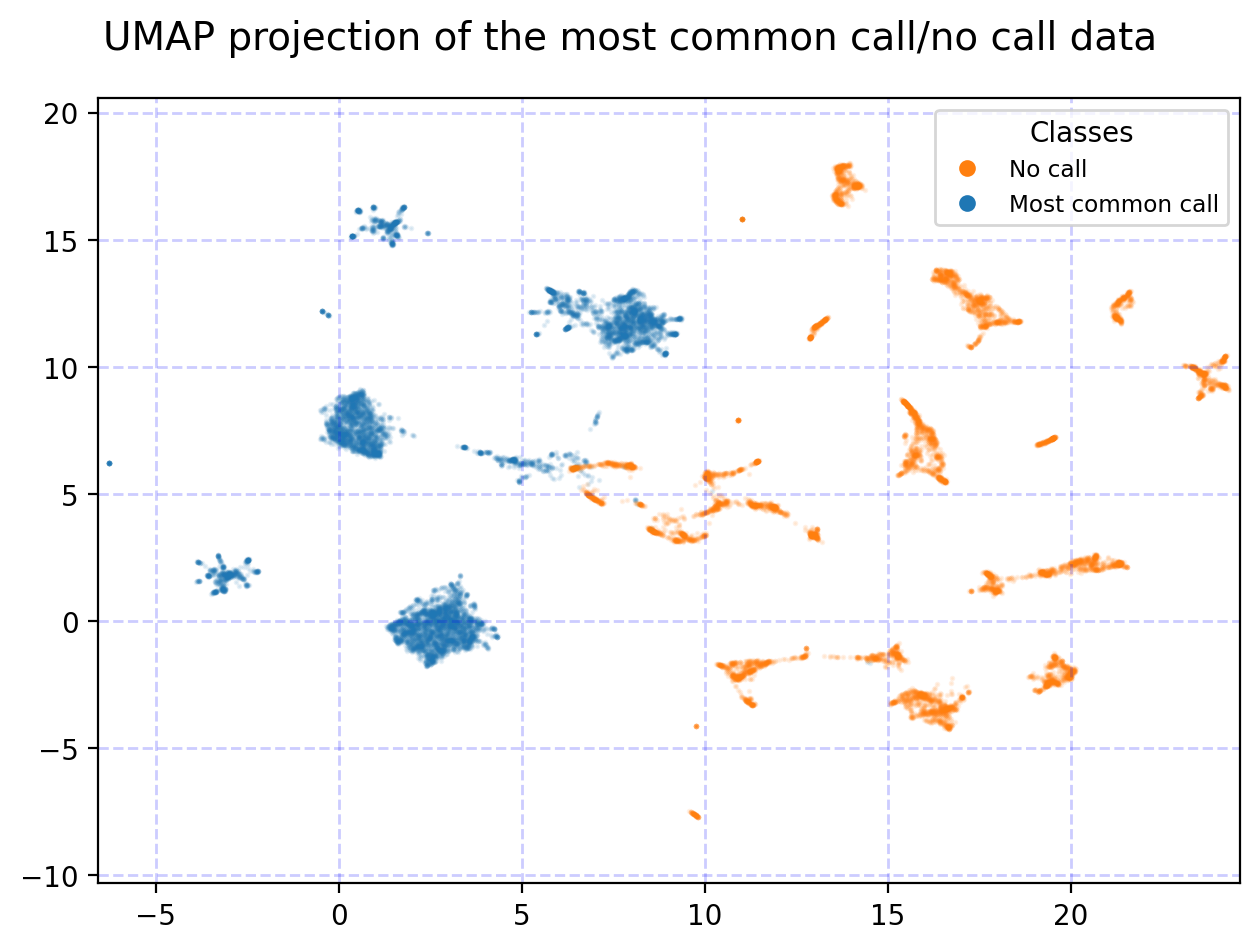

In [47]:
# Plot the data
fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
fig.suptitle("UMAP projection of the most common call/no call data", fontsize=14)
# Separate the 'call' and 'no_call' groups
embedding_call = embedding[species == 0]
embedding_no_call = embedding[species == 1]
ax.scatter(
    embedding_call[:, 0],
    embedding_call[:, 1],
    color="tab:blue",
    label="Call",
    alpha=0.1,
    s=1,
)
ax.scatter(
    embedding_no_call[:, 0],
    embedding_no_call[:, 1],
    color="tab:orange",
    label="No call",
    alpha=0.1,
    s=1,
)
ax.margins(x=0.01, y=0.1)  # No margins on x and y-axis
ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
# Set custom legend
orange_marker = mlines.Line2D(
    [], [], color="tab:orange", marker="o", ls="None", markersize=5, label="No call"
)
blue_marker = mlines.Line2D(
    [],
    [],
    color="tab:blue",
    marker="o",
    ls="None",
    markersize=5,
    label="Most common call",
)
handles = [orange_marker, blue_marker]
legend = ax.legend(loc="best", title="Classes", fontsize="small", handles=handles)
# for spine in ["top", "right", "bottom", "left"]:
#     ax.spines[spine].set_visible(False)
fig.tight_layout()
plt.show()